# Make a multipanel figure and run regressions with all the animal gut datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from rich.progress import track
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

genpath='/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome'

### Import Godon et al dataset

In [2]:
# Godon et al dataset
godon= pd.read_excel(genpath+'/Godon_data/Animal_Gut_Table_1.xlsx').rename(columns = {'Body mass (kg)':'body_mass_kg', 'Diversity':'inv_simpson', 'Name (common name)':'SampleID'})

# Categorize diets into carnivores, omnivores, and herbivores
diet=list()
omnivores=['Omnivorous']
herbivores=['Granivorous', 'Frugivorous', 'Herbivorous']
carnivores=['Piscivorous', 'Carnivorous']
for i in range(0, len(godon)):
    check = godon.loc[i, 'Feeding type']
    if check in omnivores:
        diet.append('omnivore')
    elif check in herbivores:
        diet.append('herbivore')
    elif check in carnivores:
        diet.append('carnivore')
    else:
        diet.append('NaN')
godon['diet']=diet

# Remove individuals who are neither carnivorous or herbivorous 
bin_diet = ['carnivore', 'herbivore']
godon = godon[godon['diet'].isin(bin_diet)]

# Remove extraneous columns so I can drop nans later without losing too many samples
godon = godon[['SampleID', 'body_mass_kg', 'inv_simpson', 'diet']]
godon.head()

,SampleID,body_mass_kg,inv_simpson,diet
0,Taeniopygia guttata (zebra finch),0.012,1.2,herbivore
1,Serinus canaria (canary),0.024,1.6,herbivore
2,Ramphocelus bresilius (brazilian tanager),0.035,3.4,herbivore
3,Melopsittacus undulatus (budgerigar),0.040,1.9,herbivore
4,Ploceus cucullatus (village weaver),0.040,2.3,herbivore


## Import Song and Groussin datasets and dietary data

In [3]:
# Import Song et al dietary metadata
song_metadata = pd.read_csv(genpath+'/Flo_data/Song_Metadata.txt', sep = ' ')[['SampleID', 'Diet']].rename(columns ={'Diet':'diet'})

# Import Groussin et al dietary metadata
groussin_metadata=pd.read_csv(genpath+'/Groussin_data/Groussin_Mass_and_Diet.csv')[['Sample', 'Diet']].rename(columns ={'Diet':'diet', 'Sample':'SampleID'})

# Categorize diets into herbivore, omnivore, or carnivore in the Groussin et al dataset
diet=list()
for i in range(0, len(groussin_metadata)):
    check=groussin_metadata.loc[i, 'diet']
    if check=='H':
        diet.append('herbivore')
    elif check=='O':
        diet.append('omnivore')
    elif check=='C':
        diet.append('carnivore')
    else:
        diet.append('nan')
groussin_metadata['diet']=diet

# Concatenate dietary data
diets=pd.concat([groussin_metadata, song_metadata])
diets.head()

# We generated this CSV in the vertebrate diversity notebook, which contains diversity metrics for the Song et al and the Groussin et al datasets
song_groussin = pd.read_csv(genpath+'/output/Song_Groussin_Diversity.csv').drop(columns='Unnamed: 0')

# Merge with diversity metrics with dietary metadata
song_groussin = pd.merge(song_groussin, diets, on='SampleID', how='left')

# Exclude diets that are neither carnivorous or herbivorous
bin_diet = ['carnivore', 'herbivore']
song_groussin = song_groussin[song_groussin['diet'].isin(bin_diet)]

# Add color column for identifying the datasets in the plot
song_groussin['color'] = song_groussin.dataset.apply(lambda x: '#AA4499' if x == 'Groussin et al' else '#88CCEE')


song_groussin.head()

,SampleID,simpson,body_mass_kg,dataset,inv_simpson,diet,color
0,Armadillo,0.992109,1.200,Groussin et al,126.720114,carnivore,#AA4499
2,BigHornSD,0.996773,67.130,Groussin et al,309.890951,herbivore,#AA4499
5,BlackRhino1,0.992333,986.575,Groussin et al,130.432617,herbivore,#AA4499
6,BushDog1,0.960985,5.500,Groussin et al,25.630973,carnivore,#AA4499
7,Capybara,0.994652,55.000,Groussin et al,186.975735,herbivore,#AA4499


### Log transform data

In [4]:
features = ['body_mass_kg', 'inv_simpson']

# Log transform song/groussin datasets
song_groussin[features] = song_groussin[features].apply(lambda x: np.log(x))

# Drop rows with no data
song_groussin = song_groussin.dropna()

# Log transform godon et al dataset
godon[features] = godon[features].apply(lambda x: np.log(x))

# Drop rows with no data
godon = godon.dropna()

# Check how many samples I'm working with after preprocessing
print(f"Groussin dataset n= {song_groussin[song_groussin['dataset']=='Groussin et al'].SampleID.nunique()} \n Song dataset n={song_groussin[song_groussin['dataset']=='Song et al'].SampleID.nunique()} \n Godon dataset n= {godon.SampleID.nunique()}")

Groussin dataset n= 22 
 Song dataset n=967 
 Godon dataset n= 73


### OLS regressions with and without diet/interaction term 

In [5]:
# make a dictionary with all formulas I will need to roughly estimate r squared values for each covariate
covars = ['body_mass_kg', 'C(diet)', 'body_mass_kg:C(diet)']
d_formula=dict()
d_formula[0] = {
    'formula':'inv_simpson ~ body_mass_kg + C(diet) + body_mass_kg: C(diet)',
    'excluded':'none',
    'covariates':['body_mass_kg', 'C(diet)[T.herbivore]', 'body_mass_kg:C(diet)[T.herbivore]']}
d_formula[1] = {
    'formula':'inv_simpson ~ body_mass_kg',
    'excluded':'all but mass',
    'covariates':float('NaN')}
for i in range(0,len(covars)):
    excluded=covars[i]
    temp_covars=[i for i in covars if i != excluded]
    formula=' + '.join(temp_covars)
    formula = 'inv_simpson ~ '+formula
    temp_covars=list(map(lambda x: x.replace('C(diet)', 'C(diet)[T.herbivore]'),temp_covars))
    excluded = excluded.replace('C(diet)', 'C(diet)[T.herbivore]')
    d_formula[i+2] = {
        'formula':formula,
        'excluded':excluded,
        'covariates':temp_covars}
d_formula

{0: {'formula': 'inv_simpson ~ body_mass_kg + C(diet) + body_mass_kg: C(diet)',
  'excluded': 'none',
  'covariates': ['body_mass_kg',
   'C(diet)[T.herbivore]',
   'body_mass_kg:C(diet)[T.herbivore]']},
 1: {'formula': 'inv_simpson ~ body_mass_kg',
  'excluded': 'all but mass',
  'covariates': nan},
 2: {'formula': 'inv_simpson ~ C(diet) + body_mass_kg:C(diet)',
  'excluded': 'body_mass_kg',
  'covariates': ['C(diet)[T.herbivore]', 'body_mass_kg:C(diet)[T.herbivore]']},
 3: {'formula': 'inv_simpson ~ body_mass_kg + body_mass_kg:C(diet)',
  'excluded': 'C(diet)[T.herbivore]',
  'covariates': ['body_mass_kg', 'body_mass_kg:C(diet)[T.herbivore]']},
 4: {'formula': 'inv_simpson ~ body_mass_kg + C(diet)',
  'excluded': 'body_mass_kg:C(diet)[T.herbivore]',
  'covariates': ['body_mass_kg', 'C(diet)[T.herbivore]']}}

In [6]:
def find_covar_rsq(dataframe, f_dict):
    temp = pd.DataFrame()
    temp_r = pd.DataFrame()
    for i in range(0, len(f_dict)): 
        if i==0: 
            full_model = smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit()
            full = full_model.params.reset_index().rename(columns={'index':'covar', 0:'Beta'})
            ref_r = full_model.rsquared
            full['model_rsq'] = ref_r
            full['formula']=f_dict[i]['formula']
            
            #Get pvalues
            ps = pd.DataFrame(full_model.pvalues).reset_index().rename(columns = {'index':'covar', 0:'pvalues'})
            full = pd.merge(full, ps, on = 'covar')
            
            # F test full model versus just body mass model 
            reduced_model = smf.ols(formula=f_dict[1]['formula'], data=dataframe).fit()
            F_test = anova_lm(reduced_model, full_model)
            full['F']= F_test.loc[1, 'F']
            full['F_pval'] = F_test.loc[1, 'Pr(>F)']
                
        elif i==1: 
            temp = reduced_model.params.reset_index().rename(columns={'index':'covar', 0:'Beta'})
            temp['model_rsq'] = reduced_model.rsquared
            temp['formula'] = f_dict[i]['formula']
            F_test = anova_lm(reduced_model)
            temp['F'] = F_test.loc['body_mass_kg','F']
            temp['F_pval'] = F_test.loc['body_mass_kg','PR(>F)']  
            ps = pd.DataFrame(reduced_model.pvalues).reset_index().rename(columns = {'index':'covar', 0:'pvalues'})
            temp = pd.merge(temp, ps, on = 'covar')
            full = pd.concat([full, temp]) 
        
        else: 
            results = smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit()
            # temp = results.params.reset_index().rename(columns={'index':'covar', 0:'Beta'})
            # temp.loc[i, 'model_rsq'] = ref_r #same rsquared and formula to merge on later
            temp_r.loc[i, 'formula'] = f_dict[0]['formula']
            temp_r.loc[i, 'covar_rsq'] = ref_r - results.rsquared
            temp_r.loc[i, 'covar'] = f_dict[i]['excluded']

            # pass
                 
    full = pd.merge(full, temp_r, how='left', on = ['covar', 'formula'])
    return full

g_results = find_covar_rsq(godon, d_formula)
sg_results = find_covar_rsq(song_groussin, d_formula)
g_results['dataset']='godon et al'
sg_results['dataset'] = 'song and groussin et al'

results = pd.concat([g_results, sg_results])
results = results[['dataset', 'covar', 'Beta', 'model_rsq', 'formula', 'pvalues', 'F', 'F_pval', 'covar_rsq']]
results = results[results['covar']!='Intercept'].reset_index(drop=True)
interaction_results = results.copy()

In [7]:
interaction_results

,dataset,covar,Beta,model_rsq,formula,pvalues,F,F_pval,covar_rsq
0,godon et al,C(diet)[T.herbivore],-0.008267,0.565132,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,9.371973e-01,3.498226,3.572105e-02,3.941383e-05
1,godon et al,body_mass_kg,0.009272,0.565132,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,8.095868e-01,3.498226,3.572105e-02,-2.220446e-16
2,godon et al,body_mass_kg:C(diet)[T.herbivore],0.097511,0.565132,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,1.740488e-02,3.498226,3.572105e-02,3.742144e-02
3,godon et al,body_mass_kg,0.099715,0.521038,inv_simpson ~ body_mass_kg,5.777342e-13,77.237186,5.777342e-13,NaN
4,song and groussin et al,C(diet)[T.herbivore],0.843224,0.322569,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,7.319684e-16,34.077223,4.897801e-15,4.626893e-02
5,song and groussin et al,body_mass_kg,0.144939,0.322569,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,2.224260e-08,34.077223,4.897801e-15,1.110223e-16
6,song and groussin et al,body_mass_kg:C(diet)[T.herbivore],0.008114,0.322569,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,7.659564e-01,34.077223,4.897801e-15,6.097246e-05
7,song and groussin et al,body_mass_kg,0.167149,0.275696,inv_simpson ~ body_mass_kg,3.583020e-71,375.687598,3.583020e-71,NaN


### Do this again, but without the interaction term

In [8]:
# make a dictionary with all formulas I will need to roughly estimate r squared values for each covariate
covars = ['body_mass_kg', 'C(diet)']
d_formula=dict()
d_formula[0] = {
    'formula':'inv_simpson ~ body_mass_kg + C(diet)',
    'excluded':'none',
    'covariates':['body_mass_kg', 'C(diet)[T.herbivore]']}
d_formula[1] = {
    'formula':'inv_simpson ~ body_mass_kg',
    'excluded':'all but mass',
    'covariates':float('NaN')}
for i in range(0,len(covars)):
    excluded=covars[i]
    temp_covars=[i for i in covars if i != excluded]
    formula=' + '.join(temp_covars)
    formula = 'inv_simpson ~ '+formula
    temp_covars=list(map(lambda x: x.replace('C(diet)', 'C(diet)[T.herbivore]'),temp_covars))
    excluded = excluded.replace('C(diet)', 'C(diet)[T.herbivore]')
    d_formula[i+2] = {
        'formula':formula,
        'excluded':excluded,
        'covariates':temp_covars}
d_formula

{0: {'formula': 'inv_simpson ~ body_mass_kg + C(diet)',
  'excluded': 'none',
  'covariates': ['body_mass_kg', 'C(diet)[T.herbivore]']},
 1: {'formula': 'inv_simpson ~ body_mass_kg',
  'excluded': 'all but mass',
  'covariates': nan},
 2: {'formula': 'inv_simpson ~ C(diet)',
  'excluded': 'body_mass_kg',
  'covariates': ['C(diet)[T.herbivore]']},
 3: {'formula': 'inv_simpson ~ body_mass_kg',
  'excluded': 'C(diet)[T.herbivore]',
  'covariates': ['body_mass_kg']}}

In [9]:
g_results = find_covar_rsq(godon, d_formula)
sg_results = find_covar_rsq(song_groussin, d_formula)
g_results['dataset']='godon et al'
sg_results['dataset'] = 'song and groussin et al'

results = pd.concat([g_results, sg_results])
results = results[['dataset', 'covar', 'Beta', 'model_rsq', 'formula', 'pvalues', 'F', 'F_pval', 'covar_rsq']]
results = results[results['covar']!='Intercept'].reset_index(drop=True)
non_interaction_results = results.copy()

In [10]:
non_interaction_results

,dataset,covar,Beta,model_rsq,formula,pvalues,F,F_pval,covar_rsq
0,godon et al,C(diet)[T.herbivore],0.097805,0.527711,inv_simpson ~ body_mass_kg + C(diet),3.233969e-01,0.989063,3.233969e-01,0.006673
1,godon et al,body_mass_kg,0.098742,0.527711,inv_simpson ~ body_mass_kg + C(diet),1.067651e-12,0.989063,3.233969e-01,0.507146
2,godon et al,body_mass_kg,0.099715,0.521038,inv_simpson ~ body_mass_kg,5.777342e-13,77.237186,5.777342e-13,NaN
3,song and groussin et al,C(diet)[T.herbivore],0.845600,0.322508,inv_simpson ~ body_mass_kg + C(diet),4.878336e-16,68.128762,4.878336e-16,0.046812
4,song and groussin et al,body_mass_kg,0.152156,0.322508,inv_simpson ~ body_mass_kg + C(diet),8.943043e-62,68.128762,4.878336e-16,0.218117
5,song and groussin et al,body_mass_kg,0.167149,0.275696,inv_simpson ~ body_mass_kg,3.583020e-71,375.687598,3.583020e-71,NaN


In [11]:
interaction_results

,dataset,covar,Beta,model_rsq,formula,pvalues,F,F_pval,covar_rsq
0,godon et al,C(diet)[T.herbivore],-0.008267,0.565132,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,9.371973e-01,3.498226,3.572105e-02,3.941383e-05
1,godon et al,body_mass_kg,0.009272,0.565132,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,8.095868e-01,3.498226,3.572105e-02,-2.220446e-16
2,godon et al,body_mass_kg:C(diet)[T.herbivore],0.097511,0.565132,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,1.740488e-02,3.498226,3.572105e-02,3.742144e-02
3,godon et al,body_mass_kg,0.099715,0.521038,inv_simpson ~ body_mass_kg,5.777342e-13,77.237186,5.777342e-13,NaN
4,song and groussin et al,C(diet)[T.herbivore],0.843224,0.322569,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,7.319684e-16,34.077223,4.897801e-15,4.626893e-02
5,song and groussin et al,body_mass_kg,0.144939,0.322569,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,2.224260e-08,34.077223,4.897801e-15,1.110223e-16
6,song and groussin et al,body_mass_kg:C(diet)[T.herbivore],0.008114,0.322569,inv_simpson ~ body_mass_kg + C(diet) + body_ma...,7.659564e-01,34.077223,4.897801e-15,6.097246e-05
7,song and groussin et al,body_mass_kg,0.167149,0.275696,inv_simpson ~ body_mass_kg,3.583020e-71,375.687598,3.583020e-71,NaN


In [12]:
# Saving a bunch of the results into variables I can reference for plotting later
# save p and r squared for later
g_mass_p = non_interaction_results.loc[1,'pvalues']
g_mass_r2 = non_interaction_results.loc[1,'covar_rsq']

# Save p and r squared for later 
sg_mass_p = non_interaction_results.loc[4,'pvalues']
sg_mass_r2 = non_interaction_results.loc[4,'covar_rsq']

# Get interaction effect pvalues
interaction_godon_p = interaction_results.loc[2, 'pvalues']
interaction_song_p = interaction_results.loc[6, 'pvalues']

# Get interaction effect rsquared values
interaction_godon_rsq = interaction_results.loc[2, 'covar_rsq']
interaction_song_rsq = interaction_results.loc[6, 'covar_rsq']

### Is the interaction term statistically significant across datasets? 

In [13]:
from scipy.stats import combine_pvalues 
# Given p-values 
p_values = [interaction_song_p, interaction_godon_p] 
# Using Fisher's method to combine the p-values 
combined_p_value = combine_pvalues(p_values, method='fisher') 
combined_p_value[1]

# No, the interaction term is not statistically significant across datasets

0.07089141837712792

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


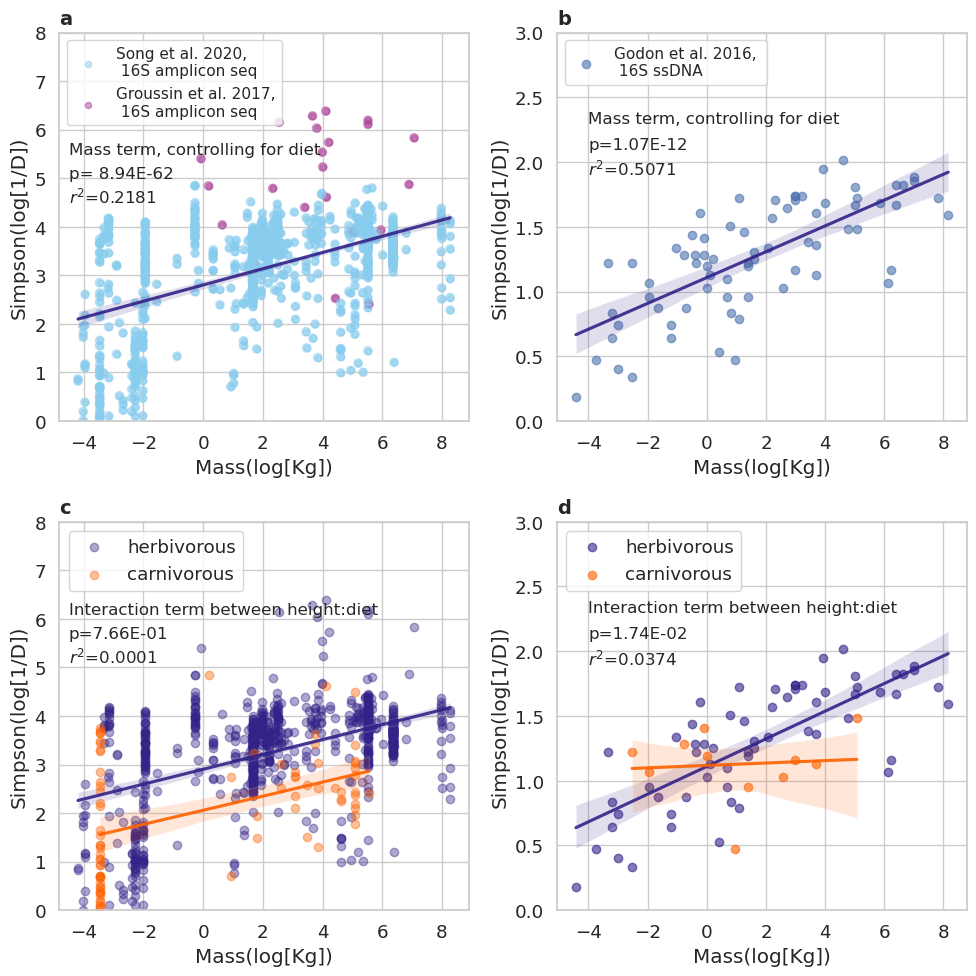

In [14]:
sns.set_theme(style='whitegrid',font_scale=1.2)
fig, axs = plt.subplots(2,2, figsize = (10,10))

x='body_mass_kg'
y= 'inv_simpson'

color_label = {'#88CCEE':'Groussin et al. 2017,\n 16S amplicon seq', '#AA4499':'Song et al. 2020,\n 16S amplicon seq'}
colors = list(song_groussin['color'].unique())
labels = [color_label[x] for x in song_groussin['color'].unique()]

sns.regplot(data = song_groussin, ax = axs[0,0],
            x=x, y=y,scatter_kws={'c':song_groussin['color'], 'color':None, 'alpha':0.5, 'zorder':1},\
            line_kws={'color':'#332288', 'alpha':0.9})

index =0
for i, grp in song_groussin.groupby(['color']):
    grp.plot(kind = 'scatter', x=x, y=y, c=i, ax = axs[0,0], label = labels[index], zorder=0, alpha = 0.5)
    # grp.plot(kind='scatter', x=x, y=y, c=i, ax=axs[0,0], zorder=0, alpha=0.5)
    index +=1
    
axs[0,0].legend(fontsize=11)
axs[0,0].text(-4.5,5.5, 'Mass term, controlling for diet', fontsize=12)  
axs[0,0].text(-4.5,5, f'p= {sg_mass_p:.2E}', fontsize = 12)
axs[0,0].text(-4.5,4.5, f'$r^2$={sg_mass_r2:.4f}', fontsize=12)
axs[0,0].set(xlabel='Mass(log[Kg])', ylabel= 'Simpson(log[1/D])')
axs[0,0].set_ylim([0,8])
axs[0,0].set_title('a', loc='left', fontweight='bold', fontsize=14) 


sns.regplot(data = godon, x=x, y=y, ax = axs[0,1],\
           scatter_kws={'alpha':0.6}, line_kws={'color':'#332288', 'alpha':0.9})

# sns.regplot(data = godon, x=x, y=y, ax = axs[1],\
           # scatter_kws={'alpha':0.6, 'color':'#44AA99'}, line_kws={'color':'#332288', 'alpha':0.9})
axs[0,1].set(xlabel='Mass(log[Kg])', ylabel= 'Simpson(log[1/D])')
axs[0,1].set_ylim([0,3])

axs[0,1].text(-4, 2.3, "Mass term, controlling for diet", fontsize=12)
axs[0,1].text(-4,2.1, f"p={g_mass_p:.2E}", fontsize=12)
axs[0,1].text(-4,1.9, f'$r^2$={g_mass_r2:.4f}', fontsize=12)

axs[0,1].set_title('b', loc='left', fontsize=14, fontweight='bold')


axs[0,1].legend(loc='upper left', fontsize=11)
axs[0,1].legend(['Godon et al. 2016, \n 16S ssDNA '],loc='upper left', fontsize=11)

sns.regplot(data = song_groussin[song_groussin['diet']=='herbivore'], ax = axs[1,0], x=x, y=y, \
           scatter_kws={'alpha':0.4, 'color':'#332288'}, line_kws={'color':'#332288', 'alpha':0.9}, label='herbivorous')
sns.regplot(data = song_groussin[song_groussin['diet']=='carnivore'], ax = axs[1,0], x=x, y=y, \
            scatter_kws={'alpha':0.4, 'color':'#FE6100'}, line_kws={'color':'#FE6100', 'alpha':0.9}, label='carnivorous')
axs[1,0].legend(loc='upper left')

axs[1,0].set(xlabel='Mass(log[Kg])', ylabel= 'Simpson(log[1/D])')
axs[1,0].set_ylim([0,8])
axs[1,0].set_title('c', loc='left', fontweight='bold', fontsize=14) 
axs[1,0].text(-4.5, 6.1, 'Interaction term between height:diet', fontsize=12)
axs[1,0].text(-4.5, 5.6, f"p={interaction_song_p:.2E}", fontsize=12)
axs[1,0].text(-4.5, 5.1, f'$r^2$={interaction_song_rsq:.4f}', fontsize=12)


sns.regplot(data = godon[godon['diet']=='herbivore'], x=x, y=y, ax = axs[1,1],\
           scatter_kws={'alpha':0.6, 'color':'#332288'}, line_kws={'color':'#332288', 'alpha':0.9}, label='herbivorous')
sns.regplot(data = godon[godon['diet']=='carnivore'], x=x, y=y, ax = axs[1,1],\
           scatter_kws={'alpha':0.6, 'color':'#FE6100'}, line_kws={'color':'#FE6100', 'alpha':0.9}, label='carnivorous')
axs[1,1].legend(loc='upper left')

axs[1,1].set(xlabel='Mass(log[Kg])', ylabel= 'Simpson(log[1/D])')
axs[1,1].set_ylim([0,3])

axs[1,1].set_title('d', loc='left', fontsize=14, fontweight='bold')
axs[1,1].text(-4, 2.3, 'Interaction term between height:diet', fontsize=12)
axs[1,1].text(-4, 2.1, f'p={interaction_godon_p:.2E}', fontsize=12)
axs[1,1].text(-4, 1.9, f'$r^2$={interaction_godon_rsq:.4f}', fontsize=12)

fig.tight_layout()



In [15]:
# Save fig
fig.savefig(genpath+'/output/vertebrate_plots.pdf')
fig.savefig(genpath+'/output/vertebrate_plots.png')